# Import modules

In [53]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import uniform, loguniform
random_state=59

In [54]:
df=pd.read_pickle('data/arbres_grenoble_clean.pkl')

# Data selection

## Removing missing years

In [55]:
#I delete the row where we don't a year for the planting
df_missing_year=df.dropna(axis=0, subset=['annee_de_plantation'])
df_clean=df.copy()
df_clean.dropna(axis=0, subset=['annee_de_plantation'], inplace=True)

## Remove sectors

In [56]:
df_clean.drop(columns=['adr_secteur'], inplace=True)

## Remove code parents and sous_categorie

In [57]:
df_clean.drop(columns=['sous_categorie', 'code_parent','collectivite','structure','geo_point_2d'], inplace=True)

# Train-test split

In [58]:
from sklearn.model_selection import train_test_split
X=df_clean.drop("annee_de_plantation", axis=1)
y=df_clean["annee_de_plantation"]


X_train, X_test, y_train, y_test= train_test_split(X, y, random_state=random_state)

# Functions

In [59]:
from sklearn.metrics import root_mean_squared_error

def show_results(model, X_train=X_train, y_train=y_train,
    X_test=X_test, y_test=y_test, graph=True):

    """
    Show two graph to compare the performance of a model
    between train data and test data
    """
    fig,(ax1, ax2)=plt.subplots(1,2,figsize=(10,5), sharey=True)

    y_test_pred = model.predict(X_test)
    y_train_pred=model.predict(X_train)
    error_test=abs(y_test_pred-y_test)
    
    rmse_test=root_mean_squared_error(y_test, y_test_pred)
    rmse_train=root_mean_squared_error(y_train, y_train_pred)
    print(f"The RMSE is:")
    print(f"Test\t{round(rmse_test,1)} years")
    print(f"Train\t{round(rmse_train,1)} years")

    if graph==True:
        sns.scatterplot(
            x=y_test,
            y=y_test_pred,
            hue=error_test,
            palette='gist_gray',
            ax=ax1
        )
        ax1.plot(y_test,y_test, linestyle='--', c='r', alpha=0.9)
        ax1.set_xlabel("Year of plantation")
        ax1.set_ylabel("Predicted year of plantation")
        ax1.get_legend().remove()
        ax1.set_title("Test data")

        
        error_train=abs(y_train_pred-y_train)
        sns.scatterplot(
            x=y_train,
            y=y_train_pred,
            hue=error_train,
            palette='gist_gray',
            ax=ax2
        )
        ax2.plot(y_train,y_train, linestyle='--', c='r', alpha=0.9)
        ax2.set_xlabel("Year of plantation")
        ax2.set_ylabel("Predicted year of plantation")
        ax2.get_legend().remove()
        ax2.set_title("Train data")

        plt.show()

# Pipeline

In [60]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder

from sklearn.linear_model import Ridge

#Columns to process
num_cols_1=['longitude','latitude']
cat_cols_1=['stade_de_developpement', 'genre espece']

num_pipeline=Pipeline([
    ('imputer',SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

cat_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='constant', fill_value='unknow')),
    ('encoder', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor_1 = ColumnTransformer([
    ('num', num_pipeline, num_cols_1),
    ('cat', cat_pipeline, cat_cols_1)
])

model=Pipeline([
    ('preprocessor', preprocessor_1),
    ('regressor', Ridge(random_state=random_state))
])

# Grid Search

## Fit

In [61]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'regressor__alpha': [1e-2, 1, 5, 50, 100]
}

grid_search = GridSearchCV(
    model, param_grid, cv=4, scoring='neg_root_mean_squared_error', 
    n_jobs=-1,
    verbose=4,
    return_train_score=True
)

grid_search.fit(X_train, y_train)

print("Meilleurs paramètres :", grid_search.best_params_)

Fitting 4 folds for each of 5 candidates, totalling 20 fits
[CV 1/4] END regressor__alpha=0.01;, score=(train=-11.324, test=-11.743) total time=   0.1s
[CV 2/4] END regressor__alpha=0.01;, score=(train=-11.361, test=-11.716) total time=   0.1s
[CV 3/4] END regressor__alpha=0.01;, score=(train=-11.410, test=-11.493) total time=   0.1s
[CV 4/4] END regressor__alpha=0.01;, score=(train=-11.388, test=-11.665) total time=   0.1s
[CV 1/4] END regressor__alpha=1;, score=(train=-11.346, test=-11.721) total time=   0.1s
[CV 2/4] END regressor__alpha=1;, score=(train=-11.388, test=-11.583) total time=   0.1s
[CV 3/4] END regressor__alpha=1;, score=(train=-11.430, test=-11.493) total time=   0.1s
[CV 4/4] END regressor__alpha=1;, score=(train=-11.415, test=-11.520) total time=   0.1s
[CV 1/4] END regressor__alpha=5;, score=(train=-11.431, test=-11.752) total time=   0.1s
[CV 2/4] END regressor__alpha=5;, score=(train=-11.482, test=-11.575) total time=   0.1s
[CV 3/4] END regressor__alpha=5;, scor

## Results

In [62]:
df_results=pd.DataFrame(grid_search.cv_results_)
dict_rename=dict(
    param_regressor__alpha='alpha'
)

df_results.rename(columns=dict_rename, inplace=True)

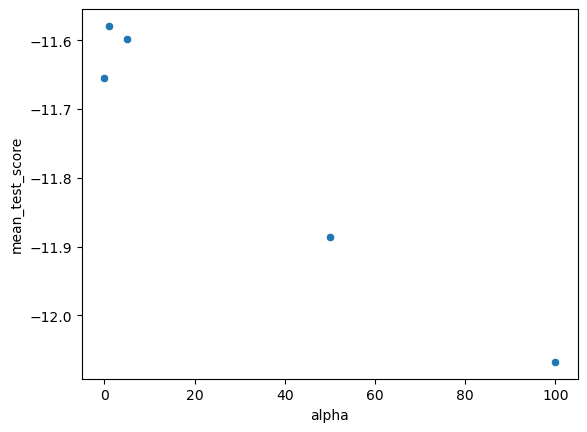

In [63]:
sns.scatterplot(
    data=df_results,
    x='alpha',
    y='mean_test_score'
)
plt.show()

# Randomized Search 1

## Fit

In [64]:
from sklearn.model_selection import RandomizedSearchCV

param_grid = {
    'regressor__alpha': loguniform(1e-2,5)
}

randomized_search = RandomizedSearchCV(
    model, param_grid, cv=4, scoring='neg_root_mean_squared_error', 
    n_jobs=-1,
    verbose=4,
    return_train_score=True,
    random_state=random_state
)

randomized_search.fit(X_train, y_train)

print("Meilleurs paramètres :", randomized_search.best_params_)

Fitting 4 folds for each of 10 candidates, totalling 40 fits
[CV 1/4] END regressor__alpha=3.1184806949954145;, score=(train=-11.396, test=-11.734) total time=   0.1s
[CV 2/4] END regressor__alpha=3.1184806949954145;, score=(train=-11.445, test=-11.564) total time=   0.1s
[CV 4/4] END regressor__alpha=3.1184806949954145;, score=(train=-11.470, test=-11.507) total time=   0.1s
[CV 3/4] END regressor__alpha=3.1184806949954145;, score=(train=-11.475, test=-11.518) total time=   0.1s
[CV 1/4] END regressor__alpha=0.026673988612551058;, score=(train=-11.324, test=-11.743) total time=   0.1s
[CV 2/4] END regressor__alpha=0.026673988612551058;, score=(train=-11.361, test=-11.710) total time=   0.1s
[CV 3/4] END regressor__alpha=0.026673988612551058;, score=(train=-11.410, test=-11.492) total time=   0.1s
[CV 4/4] END regressor__alpha=0.026673988612551058;, score=(train=-11.388, test=-11.659) total time=   0.1s
[CV 1/4] END regressor__alpha=2.18664251888846;, score=(train=-11.375, test=-11.726

## Results

In [65]:
df_results=pd.DataFrame(randomized_search.cv_results_)
dict_rename=dict(
    param_regressor__alpha='alpha'
)

df_results.rename(columns=dict_rename, inplace=True)

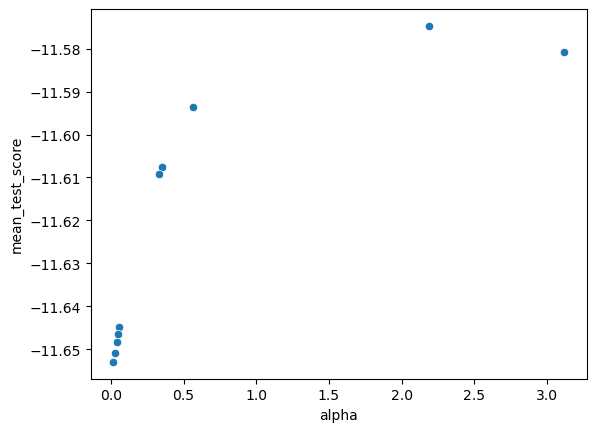

In [66]:
sns.scatterplot(
    data=df_results,
    x='alpha',
    y='mean_test_score'
)
plt.show()

# Randomized Search 2

## Fit

In [67]:
from sklearn.model_selection import RandomizedSearchCV

param_grid = {
    'regressor__alpha': uniform(loc=1,scale=3)
}

randomized_search_2 = RandomizedSearchCV(
    model, param_grid, cv=4, scoring='neg_root_mean_squared_error', 
    n_jobs=-1,
    verbose=4,
    return_train_score=True,
    random_state=random_state
)

randomized_search_2.fit(X_train, y_train)

print("Meilleurs paramètres :", randomized_search_2.best_params_)

Fitting 4 folds for each of 10 candidates, totalling 40 fits
[CV 1/4] END regressor__alpha=3.7721053467232757;, score=(train=-11.409, test=-11.740) total time=   0.1s
[CV 2/4] END regressor__alpha=3.7721053467232757;, score=(train=-11.459, test=-11.567) total time=   0.1s
[CV 4/4] END regressor__alpha=3.7721053467232757;, score=(train=-11.484, test=-11.512) total time=   0.1s
[CV 3/4] END regressor__alpha=3.7721053467232757;, score=(train=-11.487, test=-11.526) total time=   0.1s
[CV 1/4] END regressor__alpha=1.473611741604376;, score=(train=-11.358, test=-11.722) total time=   0.1s
[CV 2/4] END regressor__alpha=1.473611741604376;, score=(train=-11.403, test=-11.569) total time=   0.1s
[CV 3/4] END regressor__alpha=1.473611741604376;, score=(train=-11.441, test=-11.498) total time=   0.1s
[CV 4/4] END regressor__alpha=1.473611741604376;, score=(train=-11.429, test=-11.508) total time=   0.1s
[CV 1/4] END regressor__alpha=3.6007452304473917;, score=(train=-11.405, test=-11.738) total ti

## Results

In [68]:
df_results=pd.DataFrame(randomized_search_2.cv_results_)
dict_rename=dict(
    param_regressor__alpha='alpha'
)

df_results.rename(columns=dict_rename, inplace=True)

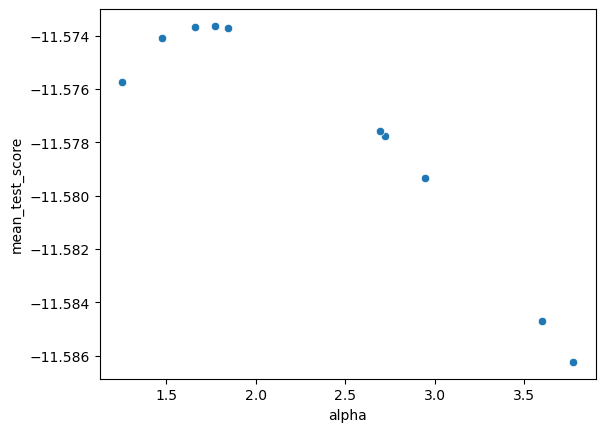

In [69]:
sns.scatterplot(
    data=df_results,
    x='alpha',
    y='mean_test_score'
)
plt.show()

# Performance best model

In [70]:
model_final=randomized_search_2.best_estimator_

The RMSE is:
Test	11.9 years
Train	11.4 years


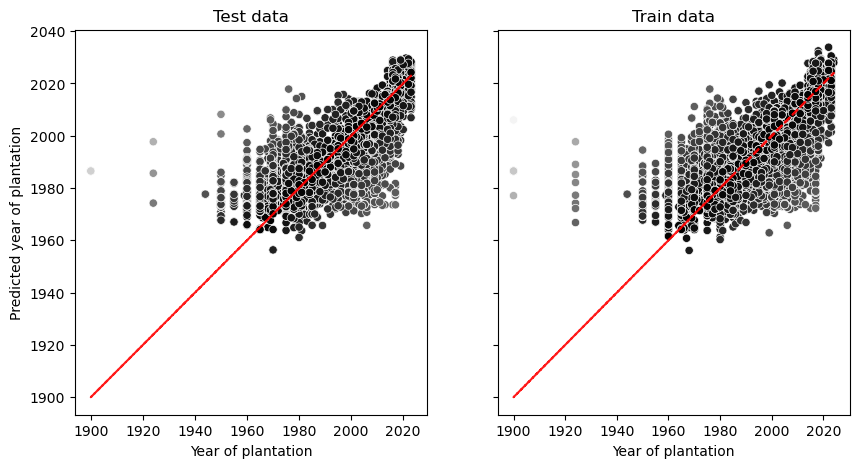

In [71]:
show_results(model_final)

# Overfitting ?

In [72]:
df_results.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,alpha,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,mean_train_score,std_train_score
0,0.052539,0.006553,0.015482,0.000456,3.772105,{'regressor__alpha': 3.7721053467232757},-11.740136,-11.566891,-11.525820,-11.512079,-11.586232,0.091116,10,-11.408534,-11.458743,-11.486669,-11.483668,-11.459403,0.031306
1,0.062236,0.004106,0.014206,0.002611,1.473612,{'regressor__alpha': 1.473611741604376},-11.721668,-11.569101,-11.497927,-11.507635,-11.574083,0.089472,4,-11.357897,-11.402539,-11.440735,-11.429323,-11.407624,0.031882
2,0.063311,0.002020,0.015193,0.003198,3.600745,{'regressor__alpha': 3.6007452304473917},-11.738359,-11.565916,-11.523814,-11.510748,-11.584709,0.091022,9,-11.405257,-11.455189,-11.483650,-11.480219,-11.456079,0.031331
3,0.074157,0.002684,0.015277,0.001566,1.252471,{'regressor__alpha': 1.2524708225843746},-11.721227,-11.574504,-11.495327,-11.511847,-11.575726,0.089046,5,-11.352192,-11.395862,-11.435593,-11.422767,-11.401604,0.031928
4,0.071769,0.006010,0.015608,0.000573,2.720721,{'regressor__alpha': 2.720721051812883},-11.730221,-11.562589,-11.513329,-11.504917,-11.577764,0.090736,7,-11.387244,-11.435531,-11.467219,-11.461354,-11.437837,0.031549


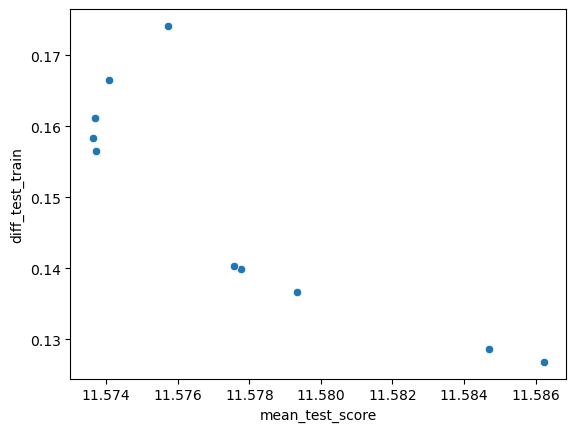

In [73]:
df_results['diff_test_train']=-df_results['mean_test_score']+df_results['mean_train_score']
df_results['mean_test_score']=-df_results['mean_test_score']
sns.scatterplot(
    data=df_results,
    x='mean_test_score',
    y='diff_test_train'
)
plt.show()